In [1]:
# load packages
import os
import csv

import numpy as np 
import pandas as pd 
import itertools
import re

import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from collections import defaultdict

from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
# set working directory
#os.chdir("/Users/deslava/Dropbox/deslava/BSE/text_mining/term_paper/")
os.chdir("/Users/philine/Dropbox/2021-2022_BSE/T2_TextMining/term_paper/")

In [3]:
# import pre-cleaned tweets data
data = pd.read_csv("data/all_english_tweets_preprocessed_v3.csv", lineterminator='\n') # .csv file
data["tokenized_text"] = data["tokenized_text"].fillna("[]").apply(lambda x: eval(x))

In [4]:
data.T.iloc[:,2000:2005]

,2000,2001,2002,2003,2004
Unnamed: 0,2000,2001,2002,2003,2004
Unnamed: 0.1,365591,365596,365599,365600,365605
userid,1083595952,30122242,1266641338000424960,915351016366845952,3405435772
username,odwa_v,riwired,gunsnroses_x_,ProSportsExtra,mrtyrdmc_
acctdesc,Love❤. Respect🙏. Live👆,"Dogs, Theater, Music, Art, Dog Training, Peace...",🇵🇰,We cover the EXTRA news! The EXTRA content. Un...,☪️Küntü Kenz/Men Arefe/Bezmi Elest☪️\nİktisat ...
location,South Africa,Broadway,NaN,United States,"İstanbul, Türkiye"
following,1508,29366,123,578,269
followers,691,26722,142,20112,58
totaltweets,4172,483069,15142,31103,1114
usercreatedts,2013-01-12 17:23:19.000000,2009-04-10 01:35:01.000000,2020-05-30 08:03:31.000000,2017-10-03 23:01:03.000000,2015-08-06 09:05:04.000000


In [5]:
print(data.shape)
data = data[data['tokenized_text'].apply(lambda x: len(x) > 5)]
print(data.shape)

(2022257, 25)
(1780896, 25)


In [6]:
line = 200001

print(data.iloc[line, 13])
print("\n")
print(data.iloc[line, 23])
print("\n")
print(data.iloc[line, 24])

Russian soldier sunbathing.

We need more of these going on Twitter. Retweet

Please like and retweet so these images can get to the real people of Russia, past #PutinHitler 

#DeadRussianSoldiers #Putler #PutinIsaWarCriminal #PutinHitler #Putin https://t.co/nmrQAMCST8


russian soldier sunbathing we need more of these going on twitter retweet please like and retweet so these images can get to the real people of russia past putinhitler deadrussiansoldiers putler putinisawarcriminal putinhitler putin


['soldier', 'sunbathing', 'need', 'going', 'twitter', 'retweet', 'please', 'like', 'retweet', 'images', 'get', 'real', 'people', 'past', 'putinhitler', 'deadrussiansoldiers', 'putler', 'putinisawarcriminal', 'putinhitler', 'putin']


## 1 Tweet pooling

### a) No Pooling

In [7]:
texts_np = data['tokenized_text']
texts_np

1          [mp, sophia, fedyna, tells, ground, situation,...
2                 [cruise, missile, fired, army, fell, kiev]
4          [wrong, absolutely, wrong, joebiden, nato, un,...
5          [rd, mechanized, brigade, continues, suffer, l...
6          [world, must, act, immediately, stake, list, d...
                                 ...                        
2022252    [us, javelins, breaks, time, destroying, recor...
2022253    [rock, singer, chicherina, cuts, flag, energod...
2022254    [monday, march, confirmation, hearings, sc, no...
2022255    [four, years, actor, comedian, volodymyr, zele...
2022256    [volumes, hell, opened, inspection, place, put...
Name: tokenized_text, Length: 1780896, dtype: object

### b) Author-based pooling

In [8]:
texts_aut = data.groupby('userid')['tokenized_text'].apply(list).reset_index()
texts_aut['tokenized_text'] = [list(itertools.chain(*document)) for document in texts_aut['tokenized_text']]

texts_aut = texts_aut['tokenized_text']
texts_aut

0         [short, compilation, important, resources, inf...
1         [important, piece, safecast, azbyb, nuclear, p...
2         [woman, fled, russianinvasion, stands, near, f...
3         [woman, founder, building, product, women, nav...
4         [rt, mediagazer, media, regulator, warns, bloc...
                                ...                        
554014    [people, even, know, play, fair, want, see, eu...
554015    [ban, political, parties, ties, media, bias, d...
554016    [found, kit, let, find, idiot, vampirekillingk...
554017    [new, twitter, uploading, days, nft, earn, sen...
554018    [war, somebody, please, help, live, dont, cost...
Name: tokenized_text, Length: 554019, dtype: object

### c) Temporal pooling

In [9]:
texts_t = data.groupby(['timestamp', 'timestamp_H', 'timestamp_M'])['tokenized_text'].apply(list).reset_index()
texts_t['tokenized_text'] = [list(itertools.chain(*document)) for document in texts_t['tokenized_text']]

texts_t = texts_t['tokenized_text']
texts_t

0        [game, anonymous, cowards, running, show, behi...
1        [important, night, scum, going, around, houses...
2        [bomb, sucks, air, lungs, vicinity, powerful, ...
3        [u, swiss, impose, new, sanctions, u, announce...
4        [police, dergachi, kharkiv, region, east, capt...
                               ...                        
27742    [currently, taking, donations, aid, specifical...
27743    [several, western, capitals, advised, citizens...
27744    [nobody, win, send, guns, weak, people, solve,...
27745    [eucopresident, alexanderdecroo, andrzejduda, ...
27746    [ngin, president, ceo, fwalti, statement, situ...
Name: tokenized_text, Length: 27747, dtype: object

In [10]:
# define pooling method used
texts=texts_t

## 2 Initial LDA analysis

In [13]:
#making bigrams and trigrams
bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
#trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
#texts_trigrams = [trigram_mod[doc] for doc in texts]

In [14]:
#manual way of switching model is to comment out this line
texts = texts_bigrams

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
print(dictionary)

dictionary.filter_extremes(no_below = 500, no_above=0.8)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(1130044 unique tokens: ['abandoned', 'abandoned_captured', 'abolishnato', 'absolutely_approve', 'abt']...)
Dictionary(3319 unique tokens: ['abandoned', 'across_world', 'actions', 'added', 'address']...)


In [15]:
#estimate the lda model
topicnumber=7

#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.1.
lda=models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber, 
                    alpha='auto', eta='auto', random_state=42)

lda.show_topics(topicnumber, 15)

[(0,
  '0.009*"us" + 0.009*"world" + 0.009*"kyiv" + 0.008*"people" + 0.008*"ukrainewar" + 0.006*"support" + 0.006*"country" + 0.005*"one" + 0.005*"like" + 0.005*"usa" + 0.005*"invasion" + 0.005*"today" + 0.004*"time" + 0.004*"help" + 0.004*"biden"'),
 (1,
  '0.012*"ukrainewar" + 0.010*"people" + 0.010*"new_nurembergtribunal" + 0.010*"passes_wages" + 0.010*"cronies_international" + 0.010*"urgent_call" + 0.010*"investigate_putin" + 0.009*"neighbour_join" + 0.009*"crime_aggression" + 0.009*"illegal_war" + 0.009*"every_day" + 0.009*"sign_rt" + 0.007*"world" + 0.007*"kyiv" + 0.007*"us"'),
 (2,
  '0.050*"nato_close" + 0.046*"sky_exclude" + 0.044*"un_security" + 0.037*"stop_aggression" + 0.027*"close_sky" + 0.025*"exclude_un" + 0.023*"aggression_nato" + 0.022*"security_council" + 0.021*"council" + 0.014*"europarl_en" + 0.009*"ua_parliament" + 0.009*"council_potus" + 0.009*"eucopresident_vonderleyen" + 0.009*"help_europe" + 0.007*"people"'),
 (3,
  '0.017*"people" + 0.010*"kyiv" + 0.009*"us" +

In [16]:
lda.alpha

array([1.366883  , 0.18594214, 0.04488792, 1.0211679 , 0.04700513,
       0.04983882, 0.05426009], dtype=float32)

## 3 Use Word2Vec to generate dictionary
We want to train our LDA on particular topics, namely:

+ Economic Sanctions
+ Geopolitics
+ Humanitarian Crisis (maybe split into two: Aid, Humanitarian Disaster)
+ Migration
+ Military operations
+ Casualties

We use Word2Vec to define a dictionary of words that we want to find in each topic, which we then feed into the LDA. The words used to train the Word2Vec are chosen by manually.

In [17]:
def tokenize(text):
    tokens = re.split(r'\W+', text)
    return tokens
corpus_data = data["cleaned_text"].astype(str).apply(tokenize)

In [18]:
corpus_data

1          [ukraine, mp, sophia, fedyna, tells, about, th...
2          [a, cruise, missile, fired, by, the, russian, ...
4          [now, this, is, wrong, absolutely, wrong, for,...
5          [rd, mechanized, brigade, continues, to, suffe...
6          [the, world, must, act, immediately, ukraine, ...
                                 ...                        
2022252    [us, javelins, breaks, the, all, time, destroy...
2022253    [russian, rock, singer, chicherina, cuts, ukra...
2022254    [monday, march, confirmation, hearings, for, s...
2022255    [for, four, years, the, actor, comedian, volod...
2022256    [when, the, volumes, of, hell, are, opened, fo...
Name: cleaned_text, Length: 1780896, dtype: object

In [19]:
corpus_list = corpus_data.tolist()
model = gensim.models.Word2Vec(corpus_list, min_count=10, vector_size=100)

In [20]:
print(np.asarray(model.wv.vectors).shape)

(69464, 100)


In [21]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 30:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/69464 is the
word #1/69464 is ukraine
word #2/69464 is to
word #3/69464 is of
word #4/69464 is and
word #5/69464 is in
word #6/69464 is russia
word #7/69464 is a
word #8/69464 is is
word #9/69464 is putin
word #10/69464 is s
word #11/69464 is for
word #12/69464 is on
word #13/69464 is russian
word #14/69464 is are
word #15/69464 is war
word #16/69464 is you
word #17/69464 is it
word #18/69464 is this
word #19/69464 is with
word #20/69464 is that
word #21/69464 is from
word #22/69464 is i
word #23/69464 is we
word #24/69464 is will
word #25/69464 is be
word #26/69464 is not
word #27/69464 is nato
word #28/69464 is by
word #29/69464 is people


In [22]:
m = 25

In [23]:
# Geopolitics
geopolitics = model.predict_output_word(['international'], topn = m)

#print(model.predict_output_word(['nato'], topn = m))
#print(model.predict_output_word(['un'], topn = m))
#print(model.predict_output_word(['council'], topn = m))
print(model.predict_output_word(['international'], topn = m))

[('law', 0.47436264), ('legion', 0.3788504), ('community', 0.14078303), ('affairs', 0.0021965734), ('court', 0.0018119217), ('relations', 0.00083031174), ('norms', 0.0006141463), ('tribunal', 0.00022180416), ('laws', 0.00010860194), ('an', 7.3467214e-05), ('pariah', 1.6643597e-05), ('committee', 1.5861813e-05), ('conventions', 1.570473e-05), ('disputes', 1.1586825e-05), ('meghalayan', 9.350718e-06), ('crime', 6.693506e-06), ('cooperation', 5.7166876e-06), ('humanitarianorganizations', 5.184717e-06), ('refugeeconvention', 4.707193e-06), ('courts', 4.3690557e-06), ('organizations', 4.1935414e-06), ('amnesty', 3.5752903e-06), ('taekwondo', 2.1809817e-06), ('violation', 2.0951065e-06), ('agreements', 1.9395259e-06)]


In [24]:
# Humanitarian Crisis
humanitarian = model.predict_output_word(['humanitarian'], topn = m)

print(model.predict_output_word(['humanitarian'], topn = m))

[('corridors', 0.99965864), ('corridor', 0.00026581806), ('aid', 4.380959e-05), ('assistance', 3.101757e-05), ('catastrophe', 7.683815e-07), ('efforts', 7.506624e-10), ('crisis', 5.4001964e-10), ('airlift', 4.009004e-10), ('cargo', 3.9711914e-10), ('crises', 3.7932565e-10), ('italymfa', 8.483529e-11), ('convoys', 5.901698e-11), ('aide', 4.9396945e-11), ('relief', 4.8539374e-11), ('supplies', 4.1710566e-11), ('purposes', 3.290452e-11), ('blockade', 2.9885195e-11), ('disaster', 2.5627628e-11), ('assistancey', 2.5602102e-11), ('appeal', 1.7604895e-11), ('access', 1.686814e-11), ('installations', 1.6840687e-11), ('facilitate', 1.3984566e-11), ('airlifts', 1.3789516e-11), ('effort', 1.2371173e-11)]


In [25]:
# Military operations
military = model.predict_output_word(['military'], topn = m)

print(model.predict_output_word(['military'], topn = m))
#print(model.predict_output_word(['attack'], topn = m))
#print(model.predict_output_word(['bombing'], topn = m))

[('equipment', 0.47270736), ('installations', 0.39709494), ('operation', 0.044342104), ('bases', 0.01899378), ('hardware', 0.018734865), ('personnel', 0.016860148), ('operations', 0.010897769), ('assistance', 0.0055939043), ('exercises', 0.0018084272), ('base', 0.0017581382), ('aid', 0.0013461922), ('equipments', 0.0013309007), ('targets', 0.0011426412), ('intervention', 0.00061232434), ('vehicles', 0.00058546424), ('contractors', 0.00052807713), ('capabilities', 0.00043879784), ('prowess', 0.00042315), ('gear', 0.0004058263), ('buildup', 0.0003154941), ('drills', 0.00022010885), ('infrastructure', 0.00020105805), ('facilities', 0.00018239436), ('assisstance', 0.00013671041), ('uniforms', 0.00013385054)]


In [26]:
'''
# Economic Sanctions

economics = model.predict_output_word(['economics'], topn = m)

print(model.predict_output_word(['economics'], topn = m))
#print(model.predict_output_word(['sanctions'], topn = m))
#print(model.predict_output_word(['business'], topn = m))
'''

"\n# Economic Sanctions\n\neconomics = model.predict_output_word(['economics'], topn = m)\n\nprint(model.predict_output_word(['economics'], topn = m))\n#print(model.predict_output_word(['sanctions'], topn = m))\n#print(model.predict_output_word(['business'], topn = m))\n"

In [27]:
'''
# Migration
migration = model.predict_output_word(['migration'], topn = m)

print(model.predict_output_word(['migration'], topn = m))
'''

"\n# Migration\nmigration = model.predict_output_word(['migration'], topn = m)\n\nprint(model.predict_output_word(['migration'], topn = m))\n"

In [28]:
#topics = [economics, geopolitics, humanitarian, migration, military]
topics = [geopolitics, humanitarian, military]

apriori = {}
n=1

for topic in topics:

    topic_list = []
    
    for word in topic:
        topic_list += [word[0]]
        
        apriori.update(dict(zip(topic_list, [n] * len(topic_list))))
        
    n += 1
        
print(apriori)

{'law': 1, 'legion': 1, 'community': 1, 'affairs': 1, 'court': 1, 'relations': 1, 'norms': 1, 'tribunal': 1, 'laws': 1, 'an': 1, 'pariah': 1, 'committee': 1, 'conventions': 1, 'disputes': 1, 'meghalayan': 1, 'crime': 1, 'cooperation': 1, 'humanitarianorganizations': 1, 'refugeeconvention': 1, 'courts': 1, 'organizations': 1, 'amnesty': 1, 'taekwondo': 1, 'violation': 1, 'agreements': 1, 'corridors': 2, 'corridor': 2, 'aid': 3, 'assistance': 3, 'catastrophe': 2, 'efforts': 2, 'crisis': 2, 'airlift': 2, 'cargo': 2, 'crises': 2, 'italymfa': 2, 'convoys': 2, 'aide': 2, 'relief': 2, 'supplies': 2, 'purposes': 2, 'blockade': 2, 'disaster': 2, 'assistancey': 2, 'appeal': 2, 'access': 2, 'installations': 3, 'facilitate': 2, 'airlifts': 2, 'effort': 2, 'equipment': 3, 'operation': 3, 'bases': 3, 'hardware': 3, 'personnel': 3, 'operations': 3, 'exercises': 3, 'base': 3, 'equipments': 3, 'targets': 3, 'intervention': 3, 'vehicles': 3, 'contractors': 3, 'capabilities': 3, 'prowess': 3, 'gear': 3, 

## 4 Apply topic dictionary to LDA

In [29]:
topicnumber = 7

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=0.0001) # create a (ntopics, nterms) matrix and fill with low number
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index, term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 500  # put a large number in there
    return eta

In [30]:
eta = create_eta(apriori
                 , dictionary, topicnumber)
eta

array([[0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       ...,
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]])

In [31]:
#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.1.
lda2=models.LdaModel(corpus, id2word=dictionary, num_topic£s=topicnumber, 
                     random_state=42, alpha='auto', eta=eta)

lda2.print_topics(topicnumber, 15)

[(0,
  '0.009*"us" + 0.009*"world" + 0.009*"kyiv" + 0.009*"people" + 0.008*"ukrainewar" + 0.006*"support" + 0.005*"country" + 0.005*"one" + 0.005*"like" + 0.005*"usa" + 0.005*"today" + 0.005*"invasion" + 0.004*"time" + 0.004*"help" + 0.004*"biden"'),
 (1,
  '0.015*"investigate_putin" + 0.015*"urgent_call" + 0.014*"crime_aggression" + 0.014*"sign_rt" + 0.013*"illegal_war" + 0.012*"every_day" + 0.011*"ukrainewar" + 0.010*"people" + 0.009*"kyiv" + 0.007*"world" + 0.007*"mariupol" + 0.007*"us" + 0.006*"today" + 0.005*"support" + 0.005*"country"'),
 (2,
  '0.059*"nato_close" + 0.053*"sky_exclude" + 0.048*"un_security" + 0.035*"stop_aggression" + 0.031*"close_sky" + 0.026*"exclude_un" + 0.023*"aggression_nato" + 0.021*"security_council" + 0.021*"council" + 0.018*"europarl_en" + 0.012*"ua_parliament" + 0.011*"council_potus" + 0.011*"eucopresident_vonderleyen" + 0.010*"help_europe" + 0.007*"eu_commission"'),
 (3,
  '0.017*"people" + 0.010*"kyiv" + 0.009*"us" + 0.007*"ukrainewar" + 0.006*"world

In [32]:
lda2.alpha

array([2.0142944 , 0.20797643, 0.04632437, 1.2091091 , 0.0471518 ,
       0.05481085, 0.0570721 ], dtype=float32)

## 5 Plot results

In [45]:
data_t = data.groupby(['timestamp', 'timestamp_H', 'timestamp_M'])['tokenized_text'].apply(list).reset_index()
data_t['tokenized_text'] = [list(itertools.chain(*document)) for document in data_t['tokenized_text']]
data_t

,timestamp,timestamp_H,timestamp_M,tokenized_text
0,01-03-2022,0,0,"[game, anonymous, cowards, running, show, behi..."
1,01-03-2022,0,1,"[important, night, scum, going, around, houses..."
2,01-03-2022,0,7,"[bomb, sucks, air, lungs, vicinity, powerful, ..."
3,01-03-2022,0,8,"[u, swiss, impose, new, sanctions, u, announce..."
4,01-03-2022,0,9,"[police, dergachi, kharkiv, region, east, capt..."
...,...,...,...,...
27742,28-02-2022,23,15,"[currently, taking, donations, aid, specifical..."
27743,28-02-2022,23,16,"[several, western, capitals, advised, citizens..."
27744,28-02-2022,23,29,"[nobody, win, send, guns, weak, people, solve,..."
27745,28-02-2022,23,30,"[eucopresident, alexanderdecroo, andrzejduda, ..."


In [46]:
get_document_topics = [lda.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#this produces a lits of tuples
print(get_document_topics[0:1])

[[(0, 0.3003283), (1, 0.0002299496), (2, 0.03636314), (3, 0.66289485), (4, 5.7153757e-05), (5, 6.059926e-05), (6, 6.59751e-05)]]


In [47]:
for topics in range(0,7):
    data_t["topic_"+str(topics)]=[x[topics][1] for x in get_document_topics]

In [48]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27747 entries, 0 to 27746
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       27747 non-null  object 
 1   timestamp_H     27747 non-null  int64  
 2   timestamp_M     27747 non-null  int64  
 3   tokenized_text  27747 non-null  object 
 4   topic_0         27747 non-null  float64
 5   topic_1         27747 non-null  float64
 6   topic_2         27747 non-null  float64
 7   topic_3         27747 non-null  float64
 8   topic_4         27747 non-null  float64
 9   topic_5         27747 non-null  float64
 10  topic_6         27747 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 2.3+ MB


In [49]:
#data_t["time_by_hour"] = pd.to_datetime(data_t['timestamp'].astype(str) + " " + data_t['timestamp_H'].astype(str) + ":00:00", format='%d-%m-%Y %H:%M:%S')
data_t["time_by_hour"] = pd.to_datetime(data_t['timestamp'].astype(str) + " " + data_t['timestamp_H'].astype(str), format='%d-%m-%Y %H')
data_t

,timestamp,timestamp_H,timestamp_M,tokenized_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,time_by_hour
0,01-03-2022,0,0,"[game, anonymous, cowards, running, show, behi...",0.300328,0.000230,0.036363,0.662895,0.000057,0.000061,0.000066,2022-03-01 00:00:00
1,01-03-2022,0,1,"[important, night, scum, going, around, houses...",0.333787,0.000627,0.031885,0.628350,0.005005,0.000165,0.000180,2022-03-01 00:00:00
2,01-03-2022,0,7,"[bomb, sucks, air, lungs, vicinity, powerful, ...",0.829981,0.002831,0.000672,0.164251,0.000704,0.000747,0.000813,2022-03-01 00:00:00
3,01-03-2022,0,8,"[u, swiss, impose, new, sanctions, u, announce...",0.573725,0.000653,0.000155,0.424945,0.000162,0.000172,0.000187,2022-03-01 00:00:00
4,01-03-2022,0,9,"[police, dergachi, kharkiv, region, east, capt...",0.739963,0.000659,0.000157,0.258694,0.000164,0.000174,0.000189,2022-03-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
27742,28-02-2022,23,15,"[currently, taking, donations, aid, specifical...",0.652236,0.000340,0.074877,0.272288,0.000080,0.000085,0.000093,2022-02-28 23:00:00
27743,28-02-2022,23,16,"[several, western, capitals, advised, citizens...",0.256469,0.000986,0.055813,0.685944,0.000245,0.000260,0.000283,2022-02-28 23:00:00
27744,28-02-2022,23,29,"[nobody, win, send, guns, weak, people, solve,...",0.346886,0.000448,0.000106,0.652203,0.000111,0.000118,0.000128,2022-02-28 23:00:00
27745,28-02-2022,23,30,"[eucopresident, alexanderdecroo, andrzejduda, ...",0.318272,0.000237,0.148982,0.532319,0.000059,0.000062,0.000068,2022-02-28 23:00:00


### 5.1 Plot by hour

In [60]:
data_t["a_length"]=len(data_t.tokenized_text)
data_t["total_length"] = data_t["a_length"].groupby(data_t['time_by_hour']).transform('sum')

#calculate total text for each topic - longer articles receive more weight
for topics in range(0,7):
    data_t["mean"+str(topics)] = data_t['topic_'+str(topics)]*data_t["a_length"]
    data_t["mean"+str(topics)] = data_t["mean"+str(topics)].groupby(data_t['time_by_hour']).transform('sum')
    
for topics in range(0,7):
    data_t["topic_"+str(topics)+"_posterior"]=(data_t["mean"+str(topics)]+lda.alpha[topics])/(data_t["total_length"]+lda.alpha.sum())

Text(0, 0.5, 'Topic share')

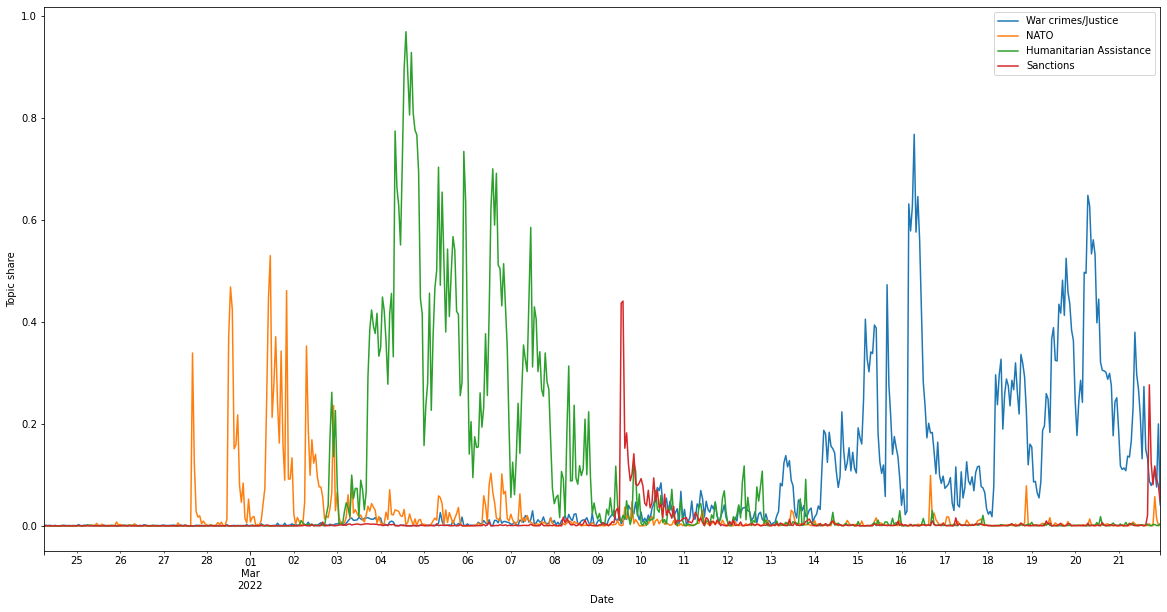

In [78]:
# Specific topics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, axs = plt.subplots(figsize=(20, 10))

data_t.groupby(data_t['time_by_hour'])["topic_1_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="War crimes/Justice")
data_t.groupby(data_t['time_by_hour'])["topic_2_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="NATO")
data_t.groupby(data_t['time_by_hour'])["topic_4_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="Humanitarian Assistance")
data_t.groupby(data_t['time_by_hour'])["topic_5_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="Sanctions")

axs.legend()

plt.xlabel("Date");  # custom x label using matplotlib
plt.ylabel("Topic share")

In [94]:
# Note: adjust timestamp/time_by_hour to the peak you want to explore
pd.set_option('display.max_colwidth', None)
data['text'][data.timestamp =="05-03-2022"].sample(10) # e.g. to explore green peak in early March

656547                                       @CocaCola #Ukraine  please close ties with Russia as money other ethically responsible companies are doing. Many of friends are currently not drinking diet coke because of your support for Russian dictatorships. Please change.
685897             @SenatorCardin @NCAADIII @Hood_MBB @JHUwbb @SalisburyWBB Ukraine needs weapons and humanitarian assistance to defend against #Putin. Stop innocent civilian deaths. @POTUS, provide #SafeAirliftUkraine #StopPutin PLEASE!CLOSE THE SKY OVER UKRAINE!PLEASE!
710662                                                                    As men, women, girls and boys are waiting to be able to flee the fighting in cities in #Ukraine, here are some #IHL rules relevant for so-called ‘humanitarian corridors’. 🧵👇 https://t.co/vhKMlOZc4Y
658460    A chartered #flight carrying evacuated Chinese students and nationals from Ukraine landed in #Hangzhou, China’s #Zhejiang on Saturday. China has moved more than 3,000 Chinese

Text(0, 0.5, 'Topic share')

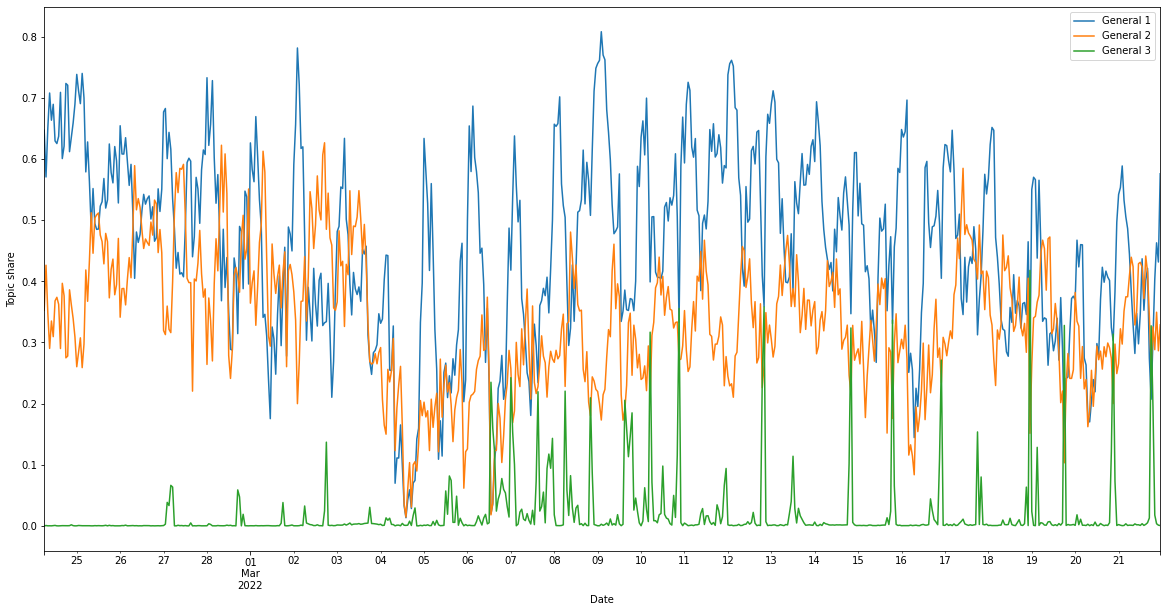

In [93]:
# General topics (non-specific)
fig, axs = plt.subplots(figsize=(20, 10))

data_t.groupby(data_t['time_by_hour'])["topic_0_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 1")
data_t.groupby(data_t['time_by_hour'])["topic_3_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 2")
data_t.groupby(data_t['time_by_hour'])["topic_6_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 3")

axs.legend()

plt.xlabel("Date");  # custom x label using matplotlib
plt.ylabel("Topic share")

### 5.2 Plot by day

In [58]:
data_t["a_length"]=len(data_t.tokenized_text)
data_t["total_length"] = data_t["a_length"].groupby(data_t['timestamp']).transform('sum')

#calculate total text for each topic - longer articles receive more weight
for topics in range(0,7):
    data_t["mean"+str(topics)] = data_t['topic_'+str(topics)]*data_t["a_length"]
    data_t["mean"+str(topics)] = data_t["mean"+str(topics)].groupby(data_t['timestamp']).transform('sum')
    
for topics in range(0,7):
    data_t["topic_"+str(topics)+"_posterior"]=(data_t["mean"+str(topics)]+lda.alpha[topics])/(data_t["total_length"]+lda.alpha.sum())

Text(0, 0.5, 'Topic share')

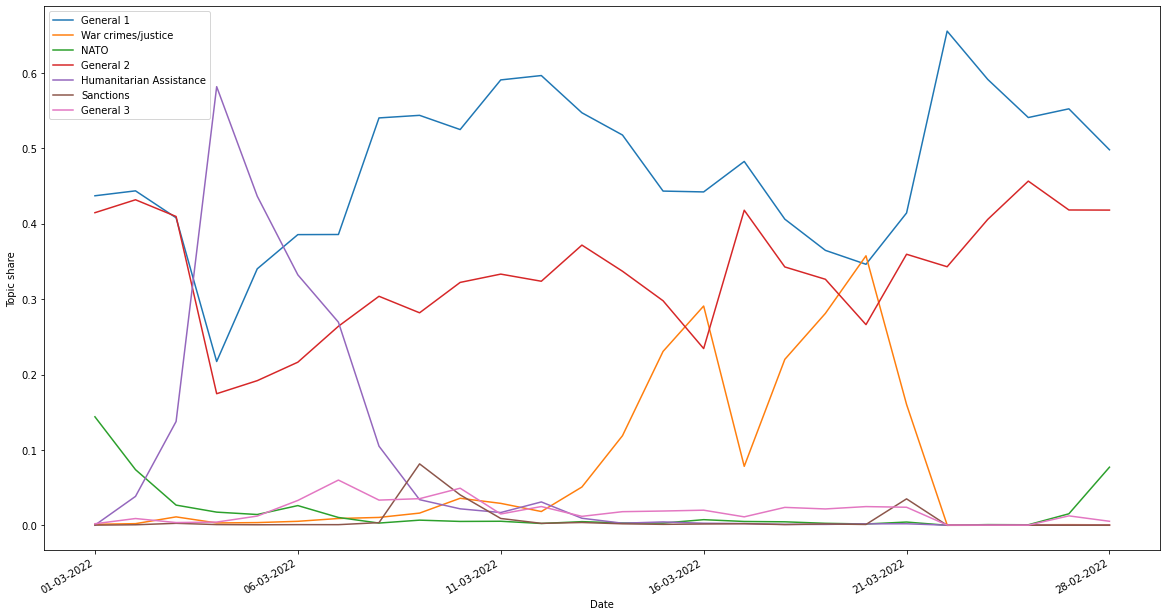

In [80]:
fig, axs = plt.subplots(figsize=(20, 10))

data_t.groupby(data_t['timestamp'])["topic_0_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 1")
data_t.groupby(data_t['timestamp'])["topic_1_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="War crimes/justice")
data_t.groupby(data_t['timestamp'])["topic_2_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="NATO")
data_t.groupby(data_t['timestamp'])["topic_3_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 2")
data_t.groupby(data_t['timestamp'])["topic_4_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="Humanitarian Assistance")
data_t.groupby(data_t['timestamp'])["topic_5_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="Sanctions")
data_t.groupby(data_t['timestamp'])["topic_6_posterior"].mean().plot(kind='line', rot=0, ax=axs, label="General 3")

axs.legend()

for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.xlabel("Date");  # custom x label using matplotlib
plt.ylabel("Topic share")